# Covid-19 NLP Pipeline


In [ ]:
#| hide
from nbdev.showdoc import show_doc
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

## Tutorial Introduction:

In this tutorial, we will guide you through the process of re-writing an existing data pipeline into the spannerlog framework, allowing you to witness a real-world example of the framework's benefits. And to offer further tutorials on advanced applications of the spannerlog framework.
We've chosen to adapt a pipeline from the field of NLP, specifically the Covid-19 NLP pipeline, which was a part of a published [paper](https://aclanthology.org/2020.nlpcovid19-acl.10.pdf) in 2020.

### Understanding The Covid-19 NLP Pipeline:

The pipline repository [link](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/).

The primary objective of the NLP pipeline is to identify individuals who have been positively diagnosed with COVID-19 by extracting pertinent information from unstructured free-text narratives found within the Electronic Health Record (EHR) of the Department of Veterans Affairs (VA). By automating this process, the pipeline streamlines the screening of a substantial volume of clinical text, significantly reducing the time and effort required for identification.
The pipeline is built on medSpacy framework, and defines a new UI to use.

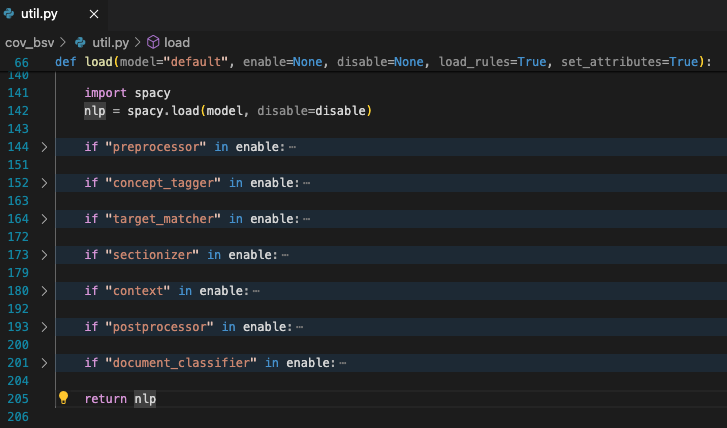


- preprocessor: 
  - removing questionnaire questions from the text 
- concept tagger: 
  - Assigns a semantic tag to certain words, which helps with concept extraction and normalization.
- target matcher: 
  - assigns tags relevant to the task such as disease tags and tags for people based on text + semantic tags
- sectionizer: 
  - Split the text into medically relevant sections
  - Assign section tags to entities in those sections
- context: 
  - Identifies semantic modifiers of entities and asserts attributes such as positive status, negation, and other experiencier.
- postprocessor: 
  -  Modifies or removes the entity based on business logic. This handles special cases or complex logic using the results of earlier stages.
- document classifier: 
  - Assigns a label of "POS", "UNK", or "NEG" to each file, A document will be classified as positive if it has at least one positive, non-excluded entity
We will explain about each stage in more details later on.

In [ ]:
# for concept tagging, we do 2 rewrites of the docs so we can regex over the transformed text



## Implementation - step by step:

### Setting Up The Environment:

We need to install some requirements to work with [medspacy](https://github.com/medspacy/medspacy) framework 

In [ ]:
#| output: false
# ! pip install spacy
# ! python -m spacy download en_core_web_sm

In [ ]:
import spacy

Installing and importing primitives from the framework

```python
! pip install spannerlib
```

In [ ]:
import re
import csv
import pandas as pd
from pandas import DataFrame
from pathlib import Path

from spannerlib import get_magic_session,Session,Span
magic_session = get_magic_session()

Defining some generic ie functions that will be used in every stage of the pipline:

In [ ]:
def read(text_path):
    """
    Reads from file and return it's content.

    Parameters:
        text_path (str): The path to the text file to read from.

    Returns:
        str: The content of the file.
    """
    Path()
    with open(f"{text_path}", 'r') as file:
        content = file.read()
    yield content

magic_session.register("read",read,[str],[str])

In [ ]:
# usage example
for value in read("sample1.txt"):
    print(value)

Patient presents to be tested for COVID-19. His wife recently tested positive for novel coronavirus. SARS-COV-2 results came back positive.


In [ ]:
def select_containing_span(spans):
    """
    This function takes a list of spans, where each span is represented
    as a list containing a label and a span (interval). It resolves overlaps
    by selecting the containing span, favoring the larger span in case of conflicts.

    Parameters:
    spans (list of lists): A list of spans, where each span is represented
        as a list [label, span].

    Returns:
    list of lists: A list of resolved spans, where each span is a list
        [label, span], with conflicts resolved by selecting the containing span.
    """
    # Sort the replacements by the size of the spans in descending order
    
    spans = sorted(spans,key=lambda span:(span.doc,span.end-span.start),reverse=True)

    # Initialize a list to keep track of intervals that have been replaced
    resolved_spans = []
    
    for span in spans:
        conflict = False

        for existing_span in resolved_spans:
            if not span.doc == existing_span.doc:
                continue
            existing_start = existing_span.start
            existing_end = existing_span.end

            if not (span.end <= existing_start or span.start >= existing_end):
                conflict = True
                break

        if not conflict:
            resolved_spans.append(span)

    return resolved_spans

In [ ]:
doc = Span("hello world",name='doc')
doc2 = Span("foo bar",name='doc2')

In [ ]:
# usage example
spans = [
    Span(doc,2, 8), 
    Span(doc,5, 9),
    Span(doc2,1,5)
    ]

resolved_spans = select_containing_span(spans)
spans,resolved_spans

([[@doc,2,8) "llo wo", [@doc,5,9) " wor", [@doc2,1,5) "oo b"],
 [[@doc,2,8) "llo wo", [@doc2,1,5) "oo b"])

In [ ]:
def rewrite(text,span_label_pairs):
    """rewrites a string given a dataframe with spans and the string to rewrite them to
    assumes that the spans belong to the text


    Args:
        text (str like): string to rewrite
        span_label_pairs (pd.Dataframe) dataframe with two columns, first is spans in the doc to rewrite
            second is what to rewrite to
    Returns:
        The rewritten string
    """    
    if isinstance(text,Span):
        text = text.as_str()
    span_label_pairs = sorted(list(span_label_pairs.itertuples(index=False,name=None)), key=lambda x: x[0].start)

    rewritten_text = ''
    current_pos = 0
    for span,label in span_label_pairs:
        rewritten_text += text[current_pos:span.start] + label 
        current_pos = span.end

    rewritten_text += text[current_pos:]

    return rewritten_text


In [ ]:
doc = Span('hello darkness my old friend, I come ...',name='doc')
doc

[@doc,0,40) "hello dark..."

In [ ]:
spans_to_replace = pd.DataFrame([
    [doc.slice(18,21),'young'],
    [doc.slice(22,28),'nemesis'],
])
spans_to_replace


,0,1
0,old,young
1,friend,nemesis


In [ ]:
rewritten_doc=rewrite(doc,spans_to_replace)
assert rewritten_doc == 'hello darkness my young nemesis, I come ...'
rewritten_doc

'hello darkness my young nemesis, I come ...'

In [ ]:
def span_contained(s1, s2):
    """
    returns (s1,s2) if s1 is contained in s2

    Parameters:
        span1 (span)
        span2 (span)

    Returns:
        (s1,s2) if s1 is contained in s2, otherwise returns nothing
    """
    if s1.doc == s2.doc and s1.start >= s2.start and s1.end <= s2.end:
        yield (s1,s2)

magic_session.register("span_contained",span_contained,[Span,Span],[Span])

In [ ]:
# usage example
span1 = Span(doc,2, 12)
span2 = Span(doc,8, 9)



assert list(span_contained(span1,span2)) == []
assert list(span_contained(span2,span1)) == [(span2,span1)]

In [ ]:
def relative_span(span1, span2):
    """
    yields the relative span of span1 in relation to span2 if they are from the same document
    otherwise yields nothing

    Parameters:
        span1 (Span): The absolute span we would like to make relative.
        span2 (Span): The refernce span we would like span1 to be relative to.

    Returns:
        Span: The new relative span of the contained one.
        None: If there's no span contained within the other.
    """
    for s1,s2 in span_contained(span1,span2):
        yield s1.slice(s1.start-s2.start,s1.end-s2.start)

magic_session.register("relative_span",relative_span, [Span,Span],[Span])

In [ ]:
# usage example 
span1 = Span(doc,2, 12)
span2 = Span(doc,2, 5)
for span in relative_span(span2, span1):
    print(span)

llo


In [ ]:
def split_sentence(text):
    """
    This function reads a text file, processes its content using spaCy's English language model,
    tokenizing it into sentences and returns each individual sentence in the processed text using a generator.
    
    Parameters:
        text_path (str): The path to the text file to be annotated.

    Returns:
        str: Individual sentences extracted from the input text.
    """

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(str(text))

    start = 0
    for sentence in doc.sents:
        end = start+len(sentence.text)
        yield Span(text,start,end)
        start = end + 1

magic_session.register('split_sentence',split_sentence,[str],[Span])

In [ ]:
text = next(read("sample1.txt"))
text

'Patient presents to be tested for COVID-19. His wife recently tested positive for novel coronavirus. SARS-COV-2 results came back positive.'

In [ ]:
assert list(split_sentence(text)) == ['Patient presents to be tested for COVID-19.',
 'His wife recently tested positive for novel coronavirus.',
 'SARS-COV-2 results came back positive.']
list(split_sentence(text))

[[@a6c01c,0,43) "Patient pr...",
 [@a6c01c,44,100) "His wife r...",
 [@a6c01c,101,139) "SARS-COV-2..."]

### Pipeline Input:

The paths of the text files to be classified should be written in "files_paths.csv" file

In [ ]:
from glob import glob

In [ ]:
input_paths = pd.DataFrame(sorted(glob('sample*.txt')))
input_paths

,0
0,sample1.txt
1,sample2.txt
2,sample3.txt
3,sample4.txt
4,sample5.txt
5,sample6.txt
6,sample7.txt


In [ ]:
magic_session.import_rel('Doc_paths',input_paths)

The initial files contents:

In [ ]:
%%spannerlog

Doc(Content) <- Doc_paths(Path),read(Path)->(Content)
?Doc( Content)

'?Doc(Content)'

,Content
0,'Patient presents to be tested for COVID-19. H...
2,'The patient was tested for COVID-19. Results ...
4,'Problem List: 1. Pneumonia 2. Novel Coronavir...
6,'neg covid education. '
8,'positive covid precaution.'
10,'The patient have reported novel coronavirus. '
12,'Elevated cholesterol levels require further a...


Before we continue we have to do some pre processing to help ease the next stages, we will certain words in each list to it's lemma forms, here a list of the words that we want to lemmatize

We will define a helper method to do that:

In [ ]:
class LemmaFromList():
    def __init__(self,lemma_list):
        self.lemma_list = lemma_list

    def __call__(self,text):
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(text)
        for word in doc:
            start = word.idx
            end = start + len(word.text)
            if word.lemma_ in self.lemma_list:
                yield (Span(text,start,end),word.lemma_)
            elif word.like_num:
                yield (Span(text,start,end),'like_num')
            else:
                pass

In [ ]:
lemma_list = Path('lemma_words.txt').read_text().split()
lemma_list[:5]

['be', 'man', 'woman', 'have', 'do']

In [ ]:
lemmatizer = LemmaFromList(lemma_list)

In [ ]:
assert list(lemmatizer('the boy was sick')) == [("was","be")]

Iterate over the texts to lemmatize them

In [ ]:
text = 'the boy was sick'
res = rewrite(text,pd.DataFrame(lemmatizer(text))) 
assert res == 'the boy be sick' 

In [ ]:
class PosFromList():
    def __init__(self,pos_list):
        self.pos_list = pos_list
    def __call__(self,text):
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(text)
        for word in doc:
            start = word.idx
            end = start + len(word.text)
            if word.pos_ in self.pos_list:
                yield (Span(text,start,end),word.pos_)


In [ ]:
pos_annotator = PosFromList(["NOUN", "PROPN", "PRON", "ADJ"])


In [ ]:
def annotate_text_with_pos(text_path):
    """
    This function reads a text file, processes its content using spaCy's English language model,
    and returns a tuple of (POS, Span) for each token if it's one of NOUN|PROPN|PRON|ADJ
    otherwise an empty tuple will be returned
    
    Parameters:
        text_path (str): The path to the text file to be annotated.

    Returns:
        tuple(str, Span): The POS of the token and it's span
    """
    with open(text_path, 'r') as file:
        contents = file.read()

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    for token in doc:
        if token.pos_ in ["NOUN", "PROPN", "PRON", "ADJ"]:
            yield token.pos_, Span(token.idx, token.idx + len(token.text))
        else:
            yield tuple()
magic_session.register(ie_function=annotate_text_with_pos, ie_function_name = "annotate_text_with_pos", in_rel=[DataTypes.string], out_rel=[DataTypes.string, DataTypes.span])

### [Concept Tagger](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/concept_tag_rules.py):

Concept tag rules, also known as pattern-based rules or custom rules, are a way to specify and define patterns that an NLP (Natural Language Processing) system should recognize within text data. These rules are used to identify specific concepts or entities within text documents. In the context of MedSpaCy and medical NLP, concept tag rules are often used to identify medical entities and concepts accurately.

In the orginal project they used the TargetRule class which defines a rule for identifying a specific concept or entity in text.
each concept Target Rule looks like this:

TargetRule(
            literal="coronavirus",
            category="COVID-19",
            pattern=[{"LOWER": {"REGEX": "coronavirus|hcov|ncov$"}}],
          )

**Literal** : This specifies the literal text or word that this rule is targeting.

**Category** : This specifies the category or label associated with the identified entity.

**Pattern** : This defines the pattern or conditions under which the entity should be recognized. It's a list of dictionaries specifying conditions for token matching. These rules some times used lemma attribute or POS of each token. A documentation can be found at : https://spacy.io/usage/rule-based-matching.

Instead what we did is to define regex patterns, we have added these pattern in concept_target_rules.csv file, there are two types of these patterns lemma and pos, that we will implement each later on.
Each rule in the csv file is like this : regexPattern, label, type

In [ ]:
print_csv_file('concept_tags_rules.csv')

(?i)(?:hcov|covid(?:(?:-)?(?:\s)?19|10)?|2019-cov|cov2|ncov-19|covd 19|no-cov|sars cov),COVID-19,lemma
(?i)(?:coivid|(?:novel )?corona(?:virus)?(?: (?:20)?19)?|sars(?:\s)?(?:-)?(?:\s)?cov(?:id)?(?:-)?(?:2|19)),COVID-19,lemma
(?i)(?:\+(?: ve)?|\(\+\)|positive|\bpos\b|active|confirmed),positive,lemma
(?i)(?:pneum(?:onia)?|pna|hypoxia|septic shoc|ards\(?(?:(?:[12])/2)\)?|(?:hypoxemic|acute|severe)? resp(?:iratory)? failure(?:\(?(?:[12]/2)\)?)?)",associated_diagnosis,lemma
(?i)(?:(?:diagnos(?:is|ed)|dx(?:\.)?)(?:of|with)?),diagnosis,lemma
(?i)(?:^screen),screening,lemma
(?i)(?:in contact with|any one|co-worker|at work|(?:the|a)(?:wo)?man|(?:another|a) (?:pt|patient|pt\.)),other_experiencer,lemma
(?i)(?:patient|pt(?:\.)?|vt|veteran),patient,lemma
(?i)(?:like_num (?:days|day|weeks|week|months|month) (?:ago|prior)),timesx,lemma
(?i)(?:(?:antibody|antibodies|ab) test),antibody test,lemma
(?i)(?:(?:coronavirus|hcovs?|ncovs?|covs?)(?:\s)?(?:-)?(?:\s)?(?: infection)?(?: strain)?(?:\s)?(?:229(?:e)

In [ ]:
magic_session.import_rel("concept_tags_rules.csv", relation_name="ConceptTagRules", delimiter=",")

### Lemma Rules:

Lemma rules are rules that used the attribute _lemma of each token in the NLP, we already lemmatized the texts, so now we can create a regex patterns for that.

Example for a lemma rule from the original NLP:

        TargetRule(
            "results positive",
            "positive",
            pattern=[
                {"LOWER": "results"},
                {"LEMMA": "be", "OP": "?"},
                {"LOWER": {"IN": ["pos", "positive"]}},
            ],
        ),
We used the py_rgx_span to capture the patterns, and will use the spans later on in replace_spans that will replace each span with the correct label

In [ ]:
%%spannerlog
LemmaMatches(Label, Span, Path) <- FilesContent(Path, Content), ConceptTagRules(Pattern, Label, "lemma"), py_rgx_span(Content, Pattern) -> (Span)

Before:

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

In [ ]:
# replace the matches with the correct label
replace_spans("LemmaMatches", "FilesPaths", magic_session)

printing results for query 'LemmaMatches(Label, Span, "sample1.txt")':
  Label   |    Span
----------+------------
 COVID-19 |  [34, 42)
 COVID-19 |  [85, 93)
 COVID-19 | [96, 104)
 positive | [123, 131)
 positive |  [72, 80)
 patient  |   [0, 7)

printing results for query 'LemmaMatches(Label, Span, "sample2.txt")':
  Label   |   Span
----------+----------
 COVID-19 | [26, 34)
 positive | [48, 56)
 patient  | [4, 11)



printing results for query 'LemmaMatches(Label, Span, "sample3.txt")':
   Label   |   Span
-----------+----------
 COVID-19  | [58, 66)
 diagnosis | [37, 46)

printing results for query 'LemmaMatches(Label, Span, "sample4.txt")':
  Label   |  Span
----------+---------
 COVID-19 | [4, 12)

printing results for query 'LemmaMatches(Label, Span, "sample5.txt")':
  Label   |  Span
----------+---------
 COVID-19 | [9, 17)
 positive | [0, 8)

printing results for query 'LemmaMatches(Label, Span, "sample6.txt")':
  Label   |   Span
----------+----------
 COVID-19 | [26, 34)
 patient  | [4, 11)

printing results for query 'LemmaMatches(Label, Span, "sample7.txt")':
[]



After:
As we can see for example in the sample1.txt, every other covid-19 name was changed to COVID-19.

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

### POS Rules:
As we mentioned above these rules used the POS attribute of each token, there were a small number of rules so we only used this to the tokens we needed.
Example of the a rule from the original NLP:

        TargetRule(
            "other experiencer",
            category="other_experiencer",
            pattern=[
                {
                    "POS": {"IN": ["NOUN", "PROPN", "PRON", "ADJ"]},
                    "LOWER": {
                        "IN": [
                            "someone",
                            "somebody",
                            "person",
                            "anyone",
                            "anybody",
                        ]
                    },
                }
            ],
        ),

The patterns we've defined will match words listed under "IN", We specifically capture words if their Part-of-Speech (POS) falls into one of the categories: ["NOUN", "PROPN", "PRON", "ADJ"]. To accomplish this, two functions are employed: the first function determines the POS of each token, and the second one, py_rgx_span, captures the predefined patterns. After matching words, We confirm the accurate POS tags of the matched words using spans.

In [ ]:
def annotate_text_with_pos(text_path):
    """
    This function reads a text file, processes its content using spaCy's English language model,
    and returns a tuple of (POS, Span) for each token if it's one of NOUN|PROPN|PRON|ADJ
    otherwise an empty tuple will be returned
    
    Parameters:
        text_path (str): The path to the text file to be annotated.

    Returns:
        tuple(str, Span): The POS of the token and it's span
    """
    with open(text_path, 'r') as file:
        contents = file.read()

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    for token in doc:
        if token.pos_ in ["NOUN", "PROPN", "PRON", "ADJ"]:
            yield token.pos_, Span(token.idx, token.idx + len(token.text))
        else:
            yield tuple()
magic_session.register(ie_function=annotate_text_with_pos, ie_function_name = "annotate_text_with_pos", in_rel=[DataTypes.string], out_rel=[DataTypes.string, DataTypes.span])

In [ ]:
# usage example
with open('example.txt', 'w') as file:
    file.write('sick boy')

for POS, span in annotate_text_with_pos('example.txt'):
    print(f"{POS}, ({span.span_start},{span.span_end})")

ADJ, (0,4)
NOUN, (5,8)


In [ ]:
%%spannerlog
POSTable(POS, Span, Path) <- FilesContent(Path, Content), annotate_text_with_pos(Path) -> (POS, Span)
?POSTable(POS, Span, Path)

POSMatches(Label, Span, Path) <- FilesContent(Path, Content), ConceptTagRules(Pattern, Label, "pos"), py_rgx_span(Content, Pattern) -> (Span)
?POSMatches(Label, Span, Path)

POSRuleMatches(Label, Span, Path) <- POSTable(POS, Span, Path), POSMatches(Label, Span, Path)
?POSRuleMatches(Label, Span, Path)

printing results for query 'POSTable(POS, Span, Path)':
  POS  |    Span    |    Path
-------+------------+-------------
  ADJ  |   [0, 7)   | sample1.txt
  ADJ  | [123, 131) | sample1.txt
  ADJ  |  [72, 80)  | sample1.txt
 NOUN  | [105, 112) | sample1.txt
 NOUN  |  [49, 55)  | sample1.txt
 NOUN  |  [8, 16)   | sample1.txt
 PRON  |  [45, 48)  | sample1.txt
 PROPN |  [34, 42)  | sample1.txt
 PROPN |  [85, 93)  | sample1.txt
 PROPN | [96, 104)  | sample1.txt
  ADJ  |  [48, 56)  | sample2.txt
 NOUN  |  [37, 44)  | sample2.txt
 NOUN  |  [4, 11)   | sample2.txt
 PROPN |  [26, 34)  | sample2.txt
 NOUN  |  [0, 12)   | sample3.txt
 PROPN |  [15, 23)  | sample3.txt
 PROPN |  [47, 55)  | sample3.txt
 PROPN |  [58, 66)  | sample3.txt
 PROPN |  [67, 75)  | sample3.txt
 NOUN  |  [13, 22)  | sample4.txt
 PROPN |   [0, 3)   | sample4.txt
 PROPN |  [4, 12)   | sample4.txt
  ADJ  |   [0, 8)   | sample5.txt
 NOUN  |  [18, 28)  | sample5.txt
 PROPN |  [9, 17)   | sample5.txt
 NOUN  |  [4, 11)   | sample6

Before:

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

In [ ]:
# replace the matches with the correct label
replace_spans("POSRuleMatches", "FilesPaths", magic_session)

printing results for query 'POSRuleMatches(Label, Span, "sample1.txt")':
  Label  |   Span
---------+----------
 family  | [49, 55)

printing results for query 'POSRuleMatches(Label, Span, "sample2.txt")':
[]

printing results for query 'POSRuleMatches(Label, Span, "sample3.txt")':
[]

printing results for query 'POSRuleMatches(Label, Span, "sample4.txt")':
[]

printing results for query 'POSRuleMatches(Label, Span, "sample5.txt")':
[]

printing results for query 'POSRuleMatches(Label, Span, "sample6.txt")':
[]

printing results for query 'POSRuleMatches(Label, Span, "sample7.txt")':
[]



After:
As we can see for example in sample1.txt, wife has changed to family.

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

### [Target Rules](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/target_rules.py):

These rules used the label that was assigned through the concept tagger, to capture some more complex patterns and assign a label for them inorder to decremnt the cases of false positive.
Each rule look like this:

        TargetRule(
            literal="coronavirus screening",
            category="IGNORE",
            pattern=[
                {"_": {"concept_tag": "COVID-19"}},
                {"LOWER": {"IN": ["screen", "screening", "screenings"]}},
            ],
        ),
Since we replaced the spans we found with the corresponding label we didn't need the concept_tag attribute of the token/span.

**Literal** : This specifies the literal text or word that this rule is targeting.

**Category** : This specifies the category or label associated with the identified entity.

**Pattern** : This defines the pattern or conditions under which the entity should be recognized. It's a list of dictionaries specifying conditions for token matching. These rules some times used lemma attribute or POS of each token. A documentation can be found at : https://spacy.io/usage/rule-based-matching.

Similar to the concept tag apporach we defined regex patterns, we have added these pattern in target_rules.csv file
Each rule in the csv file is like this : regexPattern, label

In [ ]:
print_csv_file('target_rules.csv')

(?i)(?:COVID-19 positive (?:unit|floor)|positive COVID-19 (?:unit|floor|exposure)),COVID-19
(?i)(?:known(?: positive)? COVID-19(?: positive)? (?:exposure|contact)),COVID-19
(?i)(?:COVID-19 positive screening|positive COVID-19 screening|screening COVID-19 positive|screening positive COVID-19),positive coronavirus screening
(?i)(?:diagnosis : COVID-19 (?:test|screening)),COVID-19
(?i)(?:COVID-19 screening),coronavirus screening
(?i)(?:active COVID-19 precaution|droplet isolation precaution|positive for (?:flu|influenza)|(?:the|a) positive case|results are confirm),1 2 3
(?i)(?:exposed to positive|[ ] COVID-19|age like_num(?: )?\+|(?:return|back) to work|COVID-19 infection rate),1 2 3
(?i)(?:COVID-19 (?:restriction|emergency|epidemic|outbreak|crisis|breakout|pandemic|spread|screening)|droplet precaution),1 2
(?i)(?:contact precautions|positive (?:flu|influenza)|positive (?:patient|person)|confirm (?:with|w/(?:/)?|w)|(?:the|positive) case),1 2
(?i)(?:results confirm|(?:neg|pos)\S+ pressure

In [ ]:
magic_session.import_rel("target_rules.csv", relation_name="TargetTagRules", delimiter=",")

In [ ]:
%%spannerlog
TargetTagMatches(Label, Span, Path) <- FilesContent(Path, Content), TargetTagRules(Pattern, Label), py_rgx_span(Content, Pattern) -> (Span)

Before:

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

In [ ]:
replace_spans("TargetTagMatches", "FilesPaths", magic_session)

printing results for query 'TargetTagMatches(Label, Span, "sample1.txt")':
[]

printing results for query 'TargetTagMatches(Label, Span, "sample2.txt")':
[]

printing results for query 'TargetTagMatches(Label, Span, "sample3.txt")':
[]

printing results for query 'TargetTagMatches(Label, Span, "sample4.txt")':
[]

printing results for query 'TargetTagMatches(Label, Span, "sample5.txt")':
[]

printing results for query 'TargetTagMatches(Label, Span, "sample6.txt")':
[]



printing results for query 'TargetTagMatches(Label, Span, "sample7.txt")':
[]



After:
As we can see in sample6.txt, the covid positive exposure has changed to covid, in order to not give false positive.

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

### [Section Rules](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/section_rules.py):

Here, we'll add a section detection component that defines rules for detecting sections titles, which usually appear before a semicolon.
Section rules are utilized to identify specific section names, enabling the separation of text into different parts. Entities occurring in certain sections are considered positive.

In the original project, the SectionRule class was used to define rules for identifying specific section text. Each SectionRule has the following structure

      SectionRule(category="problem_list", literal="Active Problem List:"),
      SectionRule(category="problem_list", literal="Current Problems:"),
    
    
**Literal** : This specifies the literal section text or word that this rule is targeting.

**Category** : This specifies the section category associated with the identified section.




Similar to the approach used in the concept tagger stage, regex patterns were derived from these literals, and these patterns are stored in the 'section_target_rules.csv' file and are used to match section texts and replace them with their appropriate category.

Each rule in the CSV file follows this format: regexPattern, sectionLabel

In [ ]:
print_csv_file('section_rules.csv')

(?i)(?:Lab results :),labs :
(?i)(?:Addendum :),addendum :
(?i)(?:(?:ALLERGIC REACTIONS|ALLERGIES) :),allergies :
(?i)(?:(?:CC|Chief Complaint) :),chief_complaint :
(?i)(?:COMMENTS :),comments :
(?i)(?:(?:(?:ADMISSION )?DIAGNOSES|Diagnosis|Primary Diagnosis|Primary|Secondary(?: (?:Diagnoses|Diagnosis))) :),diagnoses :
(?i)(?:(?:Brief Hospital Course|CONCISE SUMMARY OF HOSPITAL COURSE BY ISSUE/SYSTEM|HOSPITAL COURSE|SUMMARY OF HOSPITAL COURSE) :),hospital_course :
(?i)(?:(?:Imaging|MRI|INTERPRETATION|Radiology) :),imaging :
(?i)(?:(?:ADMISSION LABS|Discharge Labs|ECHO|Findings|INDICATION|Labs|Micro|Microbiology|Studies|Pertinent Results) :),labs_and_studies :
(?i)(?:(?:ACTIVE MEDICATIONS(?: LIST)|ADMISSION MEDICATIONS|CURRENT MEDICATIONS|DISCHARGE MEDICATIONS|HOME MEDICATIONS|MEDICATIONS) :),medications :
(?i)(?:(?:MEDICATIONS AT HOME|MEDICATIONS LIST|MEDICATIONS ON ADMISSION|MEDICATIONS ON DISCHARGE|MEDICATIONS ON TRANSFER|MEDICATIONS PRIOR TO ADMISSION) :),medications :
(?i)(?:Neuro :

In [ ]:
magic_session.import_rel("section_rules.csv", relation_name="SectionRules", delimiter=",")

In [ ]:
%%spannerlog
SectionRulesMatches(Label, Span, Path) <- FilesContent(Path, Content), SectionRules(Pattern, Label), py_rgx_span(Content, Pattern) -> (Span)
?SectionRulesMatches(Label, Span, Path)

printing results for query 'SectionRulesMatches(Label, Span, Path)':
[]



Before:

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

In [ ]:
replace_spans("SectionRulesMatches", "FilesPaths", magic_session)

printing results for query 'SectionRulesMatches(Label, Span, "sample1.txt")':
[]

printing results for query 'SectionRulesMatches(Label, Span, "sample2.txt")':
[]

printing results for query 'SectionRulesMatches(Label, Span, "sample3.txt")':
[]

printing results for query 'SectionRulesMatches(Label, Span, "sample4.txt")':
[]



printing results for query 'SectionRulesMatches(Label, Span, "sample5.txt")':
[]

printing results for query 'SectionRulesMatches(Label, Span, "sample6.txt")':
[]

printing results for query 'SectionRulesMatches(Label, Span, "sample7.txt")':
[]



After:
As we can see in sample 3, current problems has changed to problems_list.

In [ ]:
%%spannerlog
?FilesContent(Path, Content)

printing results for query 'FilesContent(Path, Content)':
    Path     |                                                                Content
-------------+---------------------------------------------------------------------------------------------------------------------------------------
 sample1.txt | patient presents to be tested for COVID-19 . His family recently tested positive for COVID-19 . COVID-19 results came back positive .
 sample2.txt |                                      The patient be tested for COVID-19 . Results be positive .
 sample3.txt |                              problem_list : like_num . associated_diagnosis like_num . COVID-19 like_num
 sample4.txt |                                                       neg COVID-19 education .
 sample5.txt |                                                    positive COVID-19 precaution .
 sample6.txt |                                                 The patient have reported COVID-19 .
 sample7.txt |                     

### Attribute Assertion:

 Next, we will explore how to assert attributes indicating whether a mention of COVID-19 is positive or not. In our project, we have created a table     named 'CovidAttributes' that contains all attributes for each COVID-19 mention. This table will be used for classifying documents.

In [ ]:
%%spannerlog
#Here, we employ a pattern to identify entities present in specific sections and mark them as positive,
#and adding them to the 'CovidAttributes' table.

pattern = "(?i)(?:diagnoses :|observation_and_plan :|past_medical_history :|problem_list :)(?:(?!labs :|addendum :|allergies :|chief_complaint :|comments :|family_history :|hospital_course :|imaging :|labs_and_studies :|medications :|neurological :|other :|patient_education :|physical_exam :|reason_for_examination :|signature :|social_history :).)*"
new SectionRulesAttribute(str, str)
SectionRulesAttribute(pattern, "positive")

SectionMatches(Path, Span, CovidAttribute) <- FilesContent(Path, Content), SectionRulesAttribute(Pattern, CovidAttribute), py_rgx_span(Content, Pattern) -> (Span)
?SectionMatches(Path, Span, CovidAttribute)

CovidMatches(Path, Span) <- FilesContent(Path, Content), py_rgx_span(Content, "COVID-19") -> (Span)
?CovidMatches(Path, Span)

printing results for query 'SectionMatches(Path, Span, CovidAttribute)':
    Path     |  Span   |  CovidAttribute
-------------+---------+------------------
 sample3.txt | [0, 76) |     positive

printing results for query 'CovidMatches(Path, Span)':
    Path     |   Span
-------------+-----------
 sample1.txt | [34, 42)
 sample1.txt | [85, 93)
 sample1.txt | [96, 104)
 sample2.txt | [26, 34)
 sample3.txt | [58, 66)
 sample4.txt |  [4, 12)
 sample5.txt |  [9, 17)
 sample6.txt | [26, 34)



In [ ]:
%%spannerlog
SectionCovidAttributes(Path, CovidSpan, CovidAttribute) <- SectionMatches(Path, Span1, CovidAttribute), CovidMatches(Path, Span2), is_span_contained(Span1, Span2) -> (CovidSpan)
?SectionCovidAttributes(Path, CovidSpan, CovidAttribute)

printing results for query 'SectionCovidAttributes(Path, CovidSpan, CovidAttribute)':
    Path     |  CovidSpan  |  CovidAttribute
-------------+-------------+------------------
 sample3.txt |  [58, 66)   |     positive



### Tokenizing the Text into Sentences:

In the subsequent stages, where attributes are assigned to COVID-19 mentions, a departure from the previous stages occurs. Here, patterns are no longer applied to the entire text, instead, they are applied at the sentence level, since the attributes of COVID-19 mentions are typically determined by the context of the sentence in which they appear. This means the text is processed and tokenized into sentences using spaCy's English language model. This process is accomplished through the use of  ie functions and relations.

In [ ]:
%%spannerlog
#Sentences of the text
Sents(Path, Sent) <- FilesPaths(Path), sent_tokenization(Path) -> (Sent)
?Sents(Path, Sent)

#SentSpan is the span of the sentence in the text
SentSpans(Path, Sent, SentSpan) <- FilesContent(Path, Content), Sents(Path, Sent), py_rgx_span(Content, Sent) -> (SentSpan)
?SentSpans(Path, Sent, SentSpan)

printing results for query 'Sents(Path, Sent)':
    Path     |                                        Sent
-------------+------------------------------------------------------------------------------------
 sample1.txt |                       COVID-19 results came back positive .
 sample1.txt |                 His family recently tested positive for COVID-19 .
 sample1.txt |                    patient presents to be tested for COVID-19 .
 sample2.txt |                               Results be positive .
 sample2.txt |                        The patient be tested for COVID-19 .
 sample3.txt |                                 COVID-19 like_num
 sample3.txt |                                associated_diagnosis
 sample3.txt |                                     like_num .
 sample3.txt |                             problem_list : like_num .
 sample4.txt |                              neg COVID-19 education .
 sample5.txt |                           positive COVID-19 precaution .
 sample6.txt

In [ ]:
%%spannerlog
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- SectionCovidAttributes(Path, AbsCovidSpan, CovidAttribute),\
SentSpans(Path, Sent, SentSpan) ,get_relative_span(AbsCovidSpan, SentSpan) -> (CovidSpan)
?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)

printing results for query 'CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)':
    Path     |  CovidSpan  |  CovidAttribute  |       Sent
-------------+-------------+------------------+-------------------
 sample3.txt |   [0, 8)    |     positive     | COVID-19 like_num



### [Context Rules](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/context_rules.py):

These rules assign an attribute for each COVID-19 label based on the context, these attributes will be used later to classify each text.

Example for this rule is: 

    ConTextRule(
        literal="Not Detected",
        category="NEGATED_EXISTENCE",
        direction="BACKWARD",
        pattern=[
            {"LOWER": {"IN": ["not", "non"]}},
            {"IS_SPACE": True, "OP": "*"},
            {"TEXT": "-", "OP": "?"},
            {"LOWER": {"REGEX": "detecte?d"}},
        ],
        allowed_types={"COVID-19"},
    ),
   **direction** specify if the allowed_types should be before or after the pattern,
   **allowed_types** specify on what labels should this rule be applied on 

In [ ]:
print_csv_file('context_rules.csv')

(?i)(?:positive COVID-19|COVID-19 (?:\([^)]*\)) (?:positive|detected)|COVID-19(?: positive)? associated_diagnosis)#positive
(?i)(?:COVID-19 status : positive)#positive
(?i)(?:associated_diagnosis COVID-19|associated_diagnosis (?:with|w|w//|from) (?:associated_diagnosis )?COVID-19)#positive
(?i)(?:COVID-19 positive(?: patient| precaution)?|associated_diagnosis (?:due|secondary) to COVID-19)#positive
(?i)(?:(?:current|recent) COVID-19 diagnosis)#positive
(?i)(?:COVID-19 (?:- )?related (?:admission|associated_diagnosis)|admitted (?:due to|(?:with|w|w/)) COVID-19)#positive
(?i)(?:COVID-19 infection|b34(?:\.)?2|b97.29|u07.1)#positive
(?i)(?:COVID-19 eval(?:uation)?|(?:positive )? COVID-19 symptoms|rule out COVID-19)#uncertain
(?i)(?:patient (?:do )?have COVID-19)#positive
(?i)(?:diagnosis : COVID-19(?: (?:test|screen)(?:ing|ed|s)? positive)?(?: positive)?)#positive
(?i)(?:COVID-19(?: (?!<IGNORE>)\S+)*? (?:not|non) (?:- )?detecte?d)#negated
(?i)(?:COVID-19(?: (?!<IGNORE>)\S+){0,1} negative s

In [ ]:
magic_session.import_rel("context_rules.csv", relation_name="ContextRules", delimiter="#")

In [ ]:
%%spannerlog
#covid_attributes: negated, other_experiencer, is_future, not_relevant, uncertain, positive
ContextMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), ContextRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
?ContextMatches(CovidAttribute, Span, Path, Sent)

CovidSpans(Path, Span, Sent) <- Sents(Path, Sent), py_rgx_span(Sent, "COVID-19") -> (Span)
?CovidSpans(Path, Span, Sent)

printing results for query 'ContextMatches(CovidAttribute, Span, Path, Sent)':
   CovidAttribute    |   Span   |    Path     |                        Sent
---------------------+----------+-------------+----------------------------------------------------
      positive       | [0, 17)  | sample5.txt |           positive COVID-19 precaution .
       negated       | [0, 12)  | sample4.txt |              neg COVID-19 education .
      positive       | [27, 48) | sample1.txt | His family recently tested positive for COVID-19 .
      positive       | [0, 35)  | sample1.txt |       COVID-19 results came back positive .
 patient_experiencer | [0, 34)  | sample6.txt |        The patient have reported COVID-19 .
       future        | [9, 28)  | sample5.txt |           positive COVID-19 precaution .
       future        | [4, 22)  | sample4.txt |              neg COVID-19 education .
       negated       | [4, 48)  | sample1.txt | His family recently tested positive for COVID-19 .

printing res

In [ ]:
%%spannerlog
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- ContextMatches(CovidAttribute, Span1, Path, Sent), CovidSpans(Path, Span2, Sent), is_span_contained(Span1, Span2) -> (CovidSpan)
?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)

printing results for query 'CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)':
    Path     |  CovidSpan  |   CovidAttribute    |                        Sent
-------------+-------------+---------------------+----------------------------------------------------
 sample1.txt |   [0, 8)    |      positive       |       COVID-19 results came back positive .
 sample1.txt |  [40, 48)   |       negated       | His family recently tested positive for COVID-19 .
 sample1.txt |  [40, 48)   |      positive       | His family recently tested positive for COVID-19 .
 sample3.txt |   [0, 8)    |      positive       |                 COVID-19 like_num
 sample4.txt |   [4, 12)   |       future        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       negated       |              neg COVID-19 education .
 sample5.txt |   [9, 17)   |       future        |           positive COVID-19 precaution .
 sample5.txt |   [9, 17)   |      positive       |           positive COVID-19 

### [Postprocessor](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/postprocess_rules.py):

The postprocessor is designed to apply extra adjustments to the processed text using custom logic or specific requirements not addressed by the spaCy pipeline. These rules modify, remove, or change attributes for each mention of COVID-19 based on either their existing attributes, the context of the sentences in which they appear, or a combination of both. This flexibility allows us to address data issues and implement targeted improvements. For instance, it proves useful in identifying and rectifying incorrectly labeled positive cases, thereby enhancing the accuracy of our classification.

**How we implemented it:**  
As mentioned earlier, postprocess rules are responsible for modifying, removing, or changing attributes for each mention of COVID-19. In the original project, these attributes are represented as boolean variables stored in an object class for each COVID-19 mention. The rules simply switch the corresponding boolean variable to assign or remove the attribute. However, in spannerlog, we don't have the luxury of creating classes. In our project, when we want to remove a specific attribute, we introduce an additional attribute that acts as its negation. For instance, for the attribute 'positive,' we add 'no_positive,' causing the document classifier to behave as if there is no positive attribute.

Additionally, in some cases, the entire COVID-19 mention is removed by eliminating its object. In our project, we introduce an 'IGNORE' attribute, which results in the exclusion of the mention from consideration in the document classifier stage.
<br>

**In the subsequent cells, we will explore three types of postprocess rules:**
1) Rules based on patterns
2) Rules utilizing existing attributes and patterns
3) Rules applied to the next sentence.

#### 1 - Postprocess rules based on patterns:

Example rule in the original project:

```
PostprocessingRule(
        patterns=[
            PostprocessingPattern(lambda ent: ent.label_ == "COVID-19"),
            PostprocessingPattern(
                postprocessing_functions.sentence_contains,
                condition_args=({"deny", "denies", "denied"},),
            ),
            PostprocessingPattern(
                postprocessing_functions.sentence_contains,
                condition_args=({"contact", "contacts", "confirmed"},),
            ),
        \],
        action=postprocessing_functions.remove_ent,
        description="Remove a coronavirus entity if 'denies' and 'contact' are in. This will help get rid of false positives from screening.",
    ),    
```
This rule iterates through each entity and checks a series of conditions which are the "PostprocessingPattern". If all conditions evaluate as True, then some action is taken on the entity, which is 'remove' action in this example.


In our case, we assign "IGNORE" attribute to the COVID-19 mention causing it to be excluded from consideration during the document classification process.

Each rule in the CSV file follows this format: regexPattern, Attribute

In [ ]:
print_csv_file('postprocess_pattern_rules.csv')

.*education.*#IGNORE
.* \?#IGNORE
(?=.*\b(?:deny|denies|denied)\b)(?=.*\b(?:contact|confirm)\b).*#IGNORE
(?=.*\b(?:setting of|s/o)\b)(?!.*\b(?:COVID-19 infection|COVID-19 ards)\b).*#no_positive
(?i)(.*benign.*)#uncertain
admitted to COVID-19 unit#positive


In [ ]:
magic_session.import_rel("postprocess_pattern_rules.csv", relation_name="PostprocessRules", delimiter="#")

In [ ]:
%%spannerlog
PostprocessMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), PostprocessRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
?PostprocessMatches(CovidAttribute, Span, Path, Sent)

printing results for query 'PostprocessMatches(CovidAttribute, Span, Path, Sent)':
  CovidAttribute  |  Span   |    Path     |           Sent
------------------+---------+-------------+--------------------------
      IGNORE      | [0, 24) | sample4.txt | neg COVID-19 education .



In [ ]:
%%spannerlog
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- PostprocessMatches(CovidAttribute, Span1, Path, Sent), CovidSpans(Path, Span2, Sent), is_span_contained(Span1, Span2) -> (CovidSpan)
?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)

printing results for query 'CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)':
    Path     |  CovidSpan  |   CovidAttribute    |                        Sent
-------------+-------------+---------------------+----------------------------------------------------
 sample1.txt |   [0, 8)    |      positive       |       COVID-19 results came back positive .
 sample1.txt |  [40, 48)   |       negated       | His family recently tested positive for COVID-19 .
 sample1.txt |  [40, 48)   |      positive       | His family recently tested positive for COVID-19 .
 sample3.txt |   [0, 8)    |      positive       |                 COVID-19 like_num
 sample4.txt |   [4, 12)   |       IGNORE        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       future        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       negated       |              neg COVID-19 education .
 sample5.txt |   [9, 17)   |       future        |           positive COVID-19 pre

#### 2 - Postprocess rules utilizing existing attributes and patterns:
```
PostprocessingRule(
        patterns=[
        
            PostprocessingPattern(lambda ent: ent.label_ == "COVID-19"),
            PostprocessingPattern(
                postprocessing_functions.is_modified_by_category,
                condition_args=("DEFINITE_POSITIVE_EXISTENCE",),
            ),
            # PostprocessingPattern(postprocessing_functions.is_modified_by_category, condition_args=("TEST",)),
            PostprocessingPattern(
                postprocessing_functions.sentence_contains,
                condition_args=(
                    {
                        "should",
                        "unless",
                        "either",
                        "if comes back",
                        "if returns",
                        "if s?he tests positive",
                    },
                    True,
                ),
            ),
        ],
        action=set_is_uncertain,
        action_args=(True,),
        description="Subjunctive of test returning positive. 'Will contact patient should his covid-19 test return positive.'",
    ),
```
This rule examines whether a COVID-19 mention possesses a positive attribute and if the sentence containing it includes any of the words specified in 'condition_args' If these conditions are met, the uncertain attribute is set to true.


In our case, we check for each COVID-19 mention in the 'CovidAttributes' table if it's labeled as 'positive', also, we check if any of the specified words in 'condition_args' are present in the same sentence using a regex search. If the conditions are met, then we simply assign it an 'uncertain' attribute.

Each rule in the CSV file follows this format: regexPattern, ExistingAttribute, NewAttribute


In [ ]:
print_csv_file('postprocess_attributes_rules.csv')

.*pending.*#negated#no_negated
.*(?:should|unless|either|if comes back|if returns|if s?he tests positive).*#positive#uncertain
.*precaution.*#positive#no_future
.*(?:re[ -]?test|second test|repeat).*#negated#no_negated
.*(?:sign|symptom|s/s).*#positive#uncertain


In [ ]:
magic_session.import_rel("postprocess_attributes_rules.csv", relation_name="PostprocessRulesWithAttributes", delimiter="#")

In [ ]:
%%spannerlog
PostprocessWithAttributesMatches(CovidAttribute, NewAttribute, Span, Path, Sent) <- Sents(Path, Sent), PostprocessRulesWithAttributes(Pattern, CovidAttribute, NewAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
?PostprocessWithAttributesMatches(CovidAttribute, NewAttribute, Span, Path, Sent)

printing results for query 'PostprocessWithAttributesMatches(CovidAttribute, NewAttribute, Span, Path, Sent)':
  CovidAttribute  |  NewAttribute  |  Span   |    Path     |              Sent
------------------+----------------+---------+-------------+--------------------------------
     positive     |   no_future    | [0, 30) | sample5.txt | positive COVID-19 precaution .



In [ ]:
%%spannerlog
CovidAttributes(Path, CovidSpan, NewAttribute, Sent) <- CovidAttributes(Path, CovidSpan, CovidAttribute, Sent), PostprocessWithAttributesMatches(CovidAttribute, NewAttribute, Span, Path, Sent)
?CovidAttributes(Path, CovidSpan, NewAttribute, Sent)

printing results for query 'CovidAttributes(Path, CovidSpan, NewAttribute, Sent)':
    Path     |  CovidSpan  |    NewAttribute     |                        Sent
-------------+-------------+---------------------+----------------------------------------------------
 sample1.txt |   [0, 8)    |      positive       |       COVID-19 results came back positive .
 sample1.txt |  [40, 48)   |       negated       | His family recently tested positive for COVID-19 .
 sample1.txt |  [40, 48)   |      positive       | His family recently tested positive for COVID-19 .
 sample3.txt |   [0, 8)    |      positive       |                 COVID-19 like_num
 sample4.txt |   [4, 12)   |       IGNORE        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       future        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       negated       |              neg COVID-19 education .
 sample5.txt |   [9, 17)   |       future        |           positive COVID-19 preca

#### 3 - Postprocess rules applied to the next sentence:
There's a rule that checks if the following sentence contains positive mentions. If it does, the COVID-19 mentions in the current sentence are also
marked as positive. To Implement this rule in our project, we defined a new relation that pairs each sentence with its subsequent sentence.


In [ ]:
def next_sent(text_path):
    with open(text_path, 'r') as file:
        contents = file.read()

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    # Tokenize sentences
    sentences = list(doc.sents)
    for i in range(len(sentences) - 1):  # Iterate until the second-to-last sentence
        yield(sentences[i].text, sentences[i + 1].text)

magic_session.register(ie_function=next_sent, ie_function_name = "next_sent", in_rel=[DataTypes.string], out_rel=[DataTypes.string,DataTypes.string])

In [ ]:
# usage example
for first_sent, second_sent in next_sent("sample1.txt"):
    print(f"sentence: {first_sent}", f"next sentence: {second_sent}")

sentence: patient presents to be tested for COVID-19 . next sentence: His family recently tested positive for COVID-19 .
sentence: His family recently tested positive for COVID-19 . next sentence: COVID-19 results came back positive .


In [ ]:
%%spannerlog
NextSent(Path, Sent1, Sent2) <- FilesPaths(Path), next_sent(Path) -> (Sent1, Sent2)
?NextSent(Path, Sent1, Sent2)

printing results for query 'NextSent(Path, Sent1, Sent2)':
    Path     |                       Sent1                        |                       Sent2
-------------+----------------------------------------------------+----------------------------------------------------
 sample1.txt | His family recently tested positive for COVID-19 . |       COVID-19 results came back positive .
 sample1.txt |    patient presents to be tested for COVID-19 .    | His family recently tested positive for COVID-19 .
 sample2.txt |        The patient be tested for COVID-19 .        |               Results be positive .
 sample3.txt |                associated_diagnosis                |                     like_num .
 sample3.txt |                     like_num .                     |                 COVID-19 like_num
 sample3.txt |             problem_list : like_num .              |                associated_diagnosis



In [ ]:
%%spannerlog
new PostProcessWithNextSentenceRules(str, str)
PostProcessWithNextSentenceRules("(?i)(?:^(?:positive|detected)|results?(?: be)? positive)", "positive")
PostProcessWithNextSentenceMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), PostProcessWithNextSentenceRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)

CovidAttributes(Path, CovidSpan, CovidAttribute, Sent1) <- CovidSpans(Path, CovidSpan, Sent1), NextSent(Path, Sent1, Sent2), PostProcessWithNextSentenceMatches(CovidAttribute, Span, Path, Sent2)
?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)

printing results for query 'CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)':
    Path     |  CovidSpan  |   CovidAttribute    |                        Sent
-------------+-------------+---------------------+----------------------------------------------------
 sample1.txt |   [0, 8)    |      positive       |       COVID-19 results came back positive .
 sample1.txt |  [40, 48)   |       negated       | His family recently tested positive for COVID-19 .
 sample1.txt |  [40, 48)   |      positive       | His family recently tested positive for COVID-19 .
 sample2.txt |  [26, 34)   |      positive       |        The patient be tested for COVID-19 .
 sample3.txt |   [0, 8)    |      positive       |                 COVID-19 like_num
 sample4.txt |   [4, 12)   |       IGNORE        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       future        |              neg COVID-19 education .
 sample4.txt |   [4, 12)   |       negated       |              neg COVID-19

### [Document Classifier](https://github.com/abchapman93/VA_COVID-19_NLP_BSV/blob/master/cov_bsv/knowledge_base/document_classifier.py):

Now we have the basic pieces in place to make our document classification. Each document is classified as either 'POS', 'UNK', or 'NEG' determined by the attributes of its COVID-19 mentions. The Results are stored in a DataFrame.

Document Classifier stage has 2 parts:
 1) **Attribute filtering**: Our pipeline assigns various attributes to each COVID-19 mention. However, during this stage, each COVID-19 case is refined to possess only one attribute. This filtering process operates based on specific conditions outlined in the 'attribute_filter' function.
 2) **Document classification**: Documents are classified based on distinct conditions, as detailed in the 'classify_doc_helper' function. This step ensures the accurate categorization of each document according to the specified criteria.


In [ ]:
def attribute_filter(group):
    """
    Filters attributes within each "CovidSpan" of a DataFrame table based on specific conditions.

    Parameters:
        group (pandas.Series): A pandas Series representing attributes for each "CovidSpan" within a DataFrame.

    Returns:
        str: Filtered "CovidSpan" attribute determined by the following rules:
            - If 'IGNORE' is present, returns 'IGNORE'.
            - If 'negated' is present (and 'no_negated' is not present), returns 'negated'.
            - If 'future' is present (and 'no_future' is not present), returns 'negated'.
            - If 'other experiencer' or 'not relevant' is present, returns 'negated'.
            - If 'positive' is present (and 'uncertain' and 'no_positive' are not present), returns 'positive'.
            - Otherwise, returns 'uncertain'.
    """
    if 'IGNORE' in group.values:
        return 'IGNORE'
    elif 'negated' in group.values and not 'no_negated' in group.values:
        return 'negated'
    elif 'future' in group.values and not 'no_future' in group.values:
        return 'negated'
    elif 'other experiencer' in group.values or 'not relevant' in group.values:
        return 'negated'
    elif 'positive' in group.values and not 'uncertain' in group.values and not 'no_positive' in group.values:
        return 'positive'
    else:
        return 'uncertain'

In [ ]:
# usage example
data = {'Path': ["sample1.txt", "sample1.txt", "sample1.txt", "sample2.txt"],
        'Attribute': ['IGNORE', 'negated', 'positive', 'positive']}
df_example = pd.DataFrame(data)
print("Before:")
print(df_example)

df_example['Attribute'] = df_example.groupby(['Path'])['Attribute'].transform(attribute_filter)
df_example = df_example.drop_duplicates().reset_index(drop=True)
print("\nAfter:")
print(df_example)

Before:
          Path Attribute
0  sample1.txt    IGNORE
1  sample1.txt   negated
2  sample1.txt  positive
3  sample2.txt  positive

After:
          Path Attribute
0  sample1.txt    IGNORE
1  sample2.txt  positive


In [ ]:
df = (magic_session.run_commands("?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)", print_results=False, format_results=True))[0]
if len(df) == 0:
    df = DataFrame(columns=["Path","CovidSpan","CovidAttribute"])
df['CovidAttribute'] = df.groupby(['CovidSpan', 'Sent'])['CovidAttribute'].transform(attribute_filter)
df = df.drop_duplicates().reset_index(drop=True)
df

,Path,CovidSpan,CovidAttribute,Sent
0,sample1.txt,"[0, 8)",positive,COVID-19 results came back positive .
1,sample1.txt,"[40, 48)",negated,His family recently tested positive for COVID-...
2,sample2.txt,"[26, 34)",positive,The patient be tested for COVID-19 .
3,sample3.txt,"[0, 8)",positive,COVID-19 like_num
4,sample4.txt,"[4, 12)",IGNORE,neg COVID-19 education .
5,sample5.txt,"[9, 17)",positive,positive COVID-19 precaution .
6,sample6.txt,"[26, 34)",uncertain,The patient have reported COVID-19 .


In [ ]:
def classify_doc_helper(group):
    """
Classifies a document as 'POS', 'UNK', or 'NEG' based on COVID-19 attributes.

Parameters:
    group (pandas.Series): A pandas Series representing COVID-19 attributes for each document within a DataFrame.
    
Returns:
    str: Document classification determined as follows:
         - 'POS': If at least one COVID-19 attribute with "positive" is present in the group.
         - 'UNK': If at least one COVID-19 attribute with "uncertain" is present in the group and no "positive" attributes,
                  or there's at least one COVID-19 attribute with 'IGNORE' and no other COVID-19 attributes exist.
         - 'NEG': Otherwise.
"""
    if 'positive' in group.values:
        return 'POS'
    elif 'uncertain' in group.values:
        return 'UNK'
    elif 'negated' in group.values:
        return 'NEG'
    else:
        return 'UNK'

In [ ]:
# usage example
data = {'Path': ["sample1.txt", "sample1.txt", "sample1.txt", "sample2.txt"],
        'Attribute': ['uncertain', 'negated', 'positive', 'positive']}
df_example = pd.DataFrame(data)
print("Before:")
print(df_example)

df_example['DocResult'] = df_example.groupby(['Path'])['Attribute'].transform(classify_doc_helper)
df_example = df_example[['Path', 'DocResult']]
df_example = df_example.drop_duplicates().reset_index(drop=True)
print("\nAfter:")
print(df_example)

Before:
          Path  Attribute
0  sample1.txt  uncertain
1  sample1.txt    negated
2  sample1.txt   positive
3  sample2.txt   positive

After:
          Path DocResult
0  sample1.txt       POS
1  sample2.txt       POS


In [ ]:
df['DocResult'] = df.groupby('Path')['CovidAttribute'].transform(classify_doc_helper)
df = df[['Path', 'DocResult']]
df = df.drop_duplicates().reset_index(drop=True)
df

,Path,DocResult
0,sample1.txt,POS
1,sample2.txt,POS
2,sample3.txt,POS
3,sample4.txt,UNK
4,sample5.txt,POS
5,sample6.txt,UNK


#### Handling unmentioned paths:
At this step, we assign a classification result 'UNK' to paths not identified in the previous DataFrame result. This occurs when our pipeline doesn't detect any mention of COVID-19 or its synonyms in the text of those paths. As a result, these paths are excluded from all types of relations, consistent with our primary focus on COVID-19 entities.

In [ ]:
df_path = (magic_session.run_commands("?FilesPaths(Path)", print_results=False, format_results=True))[0]
df = (pd.merge(df, df_path, on='Path', how='outer'))
df['DocResult'] = df['DocResult'].fillna("UNK")
df

,Path,DocResult
0,sample1.txt,POS
1,sample2.txt,POS
2,sample3.txt,POS
3,sample4.txt,UNK
4,sample5.txt,POS
5,sample6.txt,UNK
6,sample7.txt,UNK


## Bringing It All Together

In this section, we will directly compare the original Python Spacy pipeline project with its spannerlog counterpart. Our emphasis is on showcasing the overall brevity of the spannerlog implementation in contrast to the Python Spacy pipeline.

### Code Metrics

Let's commence by providing an estimated count of total lines in each implementation:

- **Total Number of Lines in the original Python implementation:** **4435**
- **Total Number of Lines in our spannerlog implementation:** **596** (7 times smaller!)

And here's a detailed comparison:

![code line comparison](img/line_counting.png)

With the caveat that number of lines do not fully capture code complexity, let us analyze the lines of code a little more in depth.
Analyzing our implementation vs the original we note that:

- We used the same libraries as the original implementations, so both
  - the core computations, that should turn into ie functions
  - the wrapping logic which remains in pure python
  did not significantly change in size.
- even if we assume that our 203 lines of python code are worth over 300 lines of the original implementations core and wrapping logic, we are still left with over 4000 lines of code that were converted into 393 (107+251+35) of either declarative code and data.
- This means that over 90% of the original code base, which constitutes control flow and data ingestion logic, underwent a ten-fold decrease in size while providing less surface areas for errors since declarative languages and data can be statically analyzed to a greater extent than imperative code.

### Implementation - raw lines of code

Now, we will present the combined spannerlog and python code (excluding "generic ie" functions and excluding queries) to visually illustrate the compactness of the implementation:

#### Concept tagger:
```python
def lemmatize_text(text_path, lemma_words_path):
    # Define a list of words to be lemmatized
    lemma_words = [line.strip() for line in open(f"{lemma_words_path}") if line.strip()]

    with open(text_path, 'r') as file:
        contents = file.read()

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    lemmatized_text = ""
    for token in doc:
        if token.lemma_ in lemma_words:
            lemmatized_text += token.lemma_
        elif token.like_num:
            lemmatized_text += "like_num"
        else:
            lemmatized_text += token.text
        lemmatized_text += " "

    # Write the lemmatized text back to the same file
    with open(text_path, 'w') as file:
        file.writelines(lemmatized_text)

    yield lemmatized_text

def annotate_text_with_pos(text_path):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    for token in doc:
        if token.pos_ in ["NOUN", "PROPN", "PRON", "ADJ"]:
            yield token.pos_, Span(token.idx, token.idx + len(token.text))
        else:
            yield tuple()
```

```python
session.import_rel("concept_tags_rules.csv", relation_name="ConceptTagRules", delimiter=",")

%%spannerlog
LemmaMatches(Label, Span, Path) <- FilesContent(Path, Content), ConceptTagRules(Pattern, Label, "lemma"), py_rgx_span(Content, Pattern) -> (Span)
replace_spans("LemmaMatches", "FilesPaths")
POSTable(POS, Span, Path) <- FilesContent(Path, Content), annotate_text_with_pos(Path) -> (POS, Span)
POSMatches(Label, Span, Path) <- FilesContent(Path, Content), ConceptTagRules(Pattern, Label, "pos"), py_rgx_span(Content, Pattern) -> (Span)
POSRuleMatches(Label, Span, Path) <- POSTable(POS, Span, Path), POSMatches(Label, Span, Path)
replace_spans("POSRuleMatches", "FilesPaths")
```

#### Target matcher:
```python
magic_session.import_rel("target_rules.csv", relation_name="TargetTagRules", delimiter=",")

%%spannerlog
TargetTagMatches(Label, Span, Path) <- FilesContent(Path, Content), TargetTagRules(Pattern, Label), py_rgx_span(Content,Pattern) -> (Span)
replace_spans("TargetTagMatches", "FilesPaths")
```

#### Sectionizer:
```python

magic_session.import_rel("section_rules.csv", relation_name="SectionRules", delimiter=",")

%%spannerlog
SectionRulesMatches(Label, Span, Path) <- FilesContent(Path, Content), SectionRules(Pattern, Label), py_rgx_span(Content,Pattern) -> (Span)
replace_spans("SectionRulesMatches", "FilesPaths")

pattern = "(?i)(?:diagnoses :|observation_and_plan :|past_medical_history :|problem_list :)(?:(?!labs :|addendum :|allergies :|chief_complaint :|comments :|family_history :|hospital_course :|imaging :|labs_and_studies :|medications :|neurological :|other :|patient_education :|physical_exam :|reason_for_examination :|signature :|social_history :).)*"

new SectionRulesAttribute(str, str)
SectionRulesAttribute(pattern, "positive")
SectionMatches(Path, Span, CovidAttribute) <- FilesContent(Path, Content), SectionRulesAttribute(Pattern, CovidAttribute), py_rgx_span(Content, Pattern) -> (Span)
CovidMatches(Path, Span) <- FilesContent(Path, Content), py_rgx_span(Content, "COVID-19") -> (Span)
SectionCovidAttributes(Path, CovidSpan, CovidAttribute) <- SectionMatches(Path, Span1, CovidAttribute), CovidMatches(Path, Span2), is_span_contained(Span1, Span2) -> (CovidSpan)

Sents(Path, Sent) <- FilesPaths(Path), sent_tokenization(Path) -> (Sent)
SentSpans(Path, Sent, SentSpan) <- FilesContent(Path, Content), Sents(Path, Sent), py_rgx_span(Content, Sent) -> (SentSpan)

CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- SectionCovidAttributes(Path, AbsCovidSpan, CovidAttribute),\
SentSpans(Path, Sent, SentSpan) ,get_relative_span(AbsCovidSpan, SentSpan) -> (CovidSpan)
 
```

#### Context matcher:
```python
magic_session.import_rel("context_rules.csv", relation_name="ContextRules", delimiter="#")

%%spannerlog
ContextMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), ContextRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
CovidSpans(Path, Span, Sent) <- Sents(Path, Sent), py_rgx_span(Sent, "COVID-19") -> (Span)
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- ContextMatches(CovidAttribute, Span1, Path, Sent), CovidSpans(Path, Span2, Sent), is_span_contained(Span1, Span2) -> (CovidSpan)
```

#### Postprocessor:
```python
def next_sent(text_path):
    with open(text_path, 'r') as file:
        contents = file.read()

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(contents)

    # Tokenize sentences
    sentences = list(doc.sents)
    for i in range(len(sentences) - 1):  # Iterate until the second-to-last sentence
        yield(sentences[i].text, sentences[i + 1].text)

magic_session.register(ie_function=next_sent, ie_function_name = "next_sent", in_rel=[DataTypes.string], out_rel=[DataTypes.string,DataTypes.string])
```

```python
magic_session.import_relation_from_csv("postprocess_pattern_rules.csv", relation_name="PostprocessRules", delimiter="#")

%%spannerlog
PostprocessMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), PostprocessRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent) <- PostprocessMatches(CovidAttribute, Span1, Path, Sent), CovidSpans(Path, Span2, Sent), is_span_contained(Span1, Span2) -> (CovidSpan)

NextSent(Path, Sent1, Sent2) <- FilesPaths(Path), next_sent(Path) -> (Sent1, Sent2)
new PostProcessWithNextSentenceRules(str, str)
PostProcessWithNextSentenceRules("(?i)(?:^(?:positive|detected)|results?(?: be)? positive)", "positive")
PostProcessWithNextSentenceMatches(CovidAttribute, Span, Path, Sent) <- Sents(Path, Sent), PostProcessWithNextSentenceRules(Pattern, CovidAttribute),\
py_rgx_span(Sent, Pattern) -> (Span)
CovidAttributes(Path, CovidSpan, CovidAttribute, Sent1) <- CovidSpans(Path, CovidSpan, Sent1), NextSent(Path, Sent1, Sent2), PostProcessWithNextSentenceMatches(CovidAttribute, Span, Path, Sent2)
```

#### Document Classifier:
```python
def attribute_filter(group):
    if 'IGNORE' in group.values:
        return 'IGNORE'
    elif 'negated' in group.values and not 'no_negated' in group.values:
        return 'negated'
    elif 'future' in group.values and not 'no_future' in group.values:
        return 'negated'
    elif 'other experiencer' in group.values or 'not relevant' in group.values:
        return 'negated'
    elif 'positive' in group.values and not 'uncertain' in group.values and not 'no_positive' in group.values:
        return 'positive'
    else:
        return 'uncertain'

df = (magic_session.run_commands("?CovidAttributes(Path, CovidSpan, CovidAttribute, Sent)", print_results=False, format_results=True))[0]
if len(df) == 0:
    df = DataFrame(columns=["Path","CovidSpan","CovidAttribute"])
df['CovidAttribute'] = df.groupby(['CovidSpan', 'Sent'])['CovidAttribute'].transform(attribute_filter)
df = df.drop_duplicates().reset_index(drop=True)

def classify_doc_helper(group):
    if 'positive' in group.values:
        return 'POS'
    elif 'uncertain' in group.values:
        return 'UNK'
    elif 'negated' in group.values:
        return 'NEG'
    else:
        return 'UNK'
        
df['DocResult'] = df.groupby('Path')['CovidAttribute'].transform(classify_doc_helper)
df = df[['Path', 'DocResult']]
df = df.drop_duplicates().reset_index(drop=True)

df_path = (magic_session.run_commands("?FilesPaths(Path)", print_results=False, format_results=True))[0]
df = (pd.merge(df, df_path, on='Path', how='outer'))
df['DocResult'] = df['DocResult'].fillna("UNK")
df
```